<a href="https://colab.research.google.com/github/qylisayu/Stock-Return-Prediction-Using-Sentiment-Analysis-Technical-Indicators-and-Fundamentals/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [350]:
import numpy as np
import pandas as pd

In [351]:
''' includes US stock symbols with market cap > 100 Million, and price above $3. 
Download the csv file:
https://www.nasdaq.com/market-activity/stocks/screener?exchange=nasdaq&letter=0&render=download 
for all of the NYSE, NASDAQ and NYSEAMERICAN public traded companies.
'''

' includes US stock symbols with market cap > 100 Million, and price above $3. \nDownload the csv file:\nhttps://www.nasdaq.com/market-activity/stocks/screener?exchange=nasdaq&letter=0&render=download \nfor all of the NYSE, NASDAQ and NYSEAMERICAN public traded companies.\n'

In [380]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [381]:
stocks = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP Stock Project/tickers.csv')
stocks.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Symbol      8077 non-null   object 
 1   Name        8077 non-null   object 
 2   Last Sale   8077 non-null   object 
 3   Net Change  8077 non-null   float64
 4   % Change    8075 non-null   object 
 5   Market Cap  7461 non-null   float64
 6   Country     7309 non-null   object 
 7   IPO Year    4752 non-null   float64
 8   Volume      8077 non-null   int64  
 9   Sector      6136 non-null   object 
 10  Industry    6148 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 694.2+ KB


In [382]:
# Last Sale column is an object, let's convert to float
stocks['Last Sale'] = stocks['Last Sale'].str.replace('$', '')
stocks['Last Sale'] = pd.to_numeric(stocks['Last Sale'], downcast='float')
type(stocks['Last Sale'][0])

numpy.float32

In [383]:
# Filter out stocks >$3 and > $100 million cap
price_filter = stocks['Last Sale'] >= 3.00
cap_filter = stocks['Market Cap'] >= 100000000

In [384]:
type(stocks)

pandas.core.frame.DataFrame

In [385]:
# make set of symbols
stocks = set(stocks[(price_filter) & (cap_filter)]['Symbol'])

In [386]:
# Includes common words and words used on wsb that are also stock names
blacklist = {'X', 'Y', 'I', 'ELON', 'WSB', 'THE', 'A', 'ROPE', 'YOLO', 'TOS', 'CEO', 'DD', 'IT', 'OPEN', 'ATH', 'PM', 'IRS', 'FOR','DEC', 'BE', 'IMO', 'ALL', 'RH', 'EV', 'TOS', 'CFO', 'CTO', 'DD', 'BTFD', 'WSB', 'OK', 'PDT', 'RH', 'KYS', 'FD', 'TYS', 'US', 'USA', 'IT', 'ATH', 'RIP', 'BMW', 'GDP', 'OTM', 'ATM', 'ITM', 'IMO', 'LOL', 'AM', 'BE', 'PR', 'PRAY', 'PT', 'FBI', 'SEC', 'GOD', 'NOT', 'POS', 'FOMO', 'TL;DR', 'EDIT', 'STILL', 'WTF', 'RAW', 'PM', 'LMAO', 'LMFAO', 'ROFL', 'EZ', 'RED', 'BEZOS', 'TICK', 'IS', 'PM', 'LPT', 'GOAT', 'FL', 'CA', 'IL', 'MACD', 'HQ', 'OP', 'PS', 'AH', 'TL', 'JAN', 'FEB', 'JUL', 'AUG', 'SEP', 'SEPT', 'OCT', 'NOV', 'FDA', 'IV', 'ER', 'IPO', 'MILF', 'BUT', 'SSN', 'FIFA', 'USD', 'CPU', 'AT', 'GG', 'Mar'}


In [387]:

# Adding wsb/reddit flavor to vader to improve sentiment analysis, score: 4.0 to -4.0
new_words = {
    'citron': -4.0,  
    'hindenburg': -4.0,        
    'moon': 4.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,    
    'put': -4.0,
    'puts': -4.0,    
    'break': 2.0,
    'tendie': 2.0,
     'tendies': 2.0,
     'town': 2.0,     
     'overvalued': -3.0,
     'undervalued': 3.0,
     'buy': 4.0,
     'sell': -4.0,
     'gone': -1.0,
     'gtfo': -1.7,
     'btfd': 1.7,
     'paper': -1.7,
     'bullish': 3.7,
     'bearish': -3.7,
     'bagholder': -1.7,
     'stonk': 1.9,
     'green': 1.9,
     'money': 1.2,
     'print': 2.2,
     'rocket': 3.5,
     'bull': 2.9,
     'bullish':2.9,
     'bear': -2.9,
     'bearish': -2.9,
     'pumping': -1.0,
     'sus': -3.0,
     'offering': -2.3,
     'rip': -4.0,
     'downgrade': -3.0,
     'upgrade': 3.0,     
     'maintain': 1.0,          
     'pump': 1.9,
     'hot': 1.5,
     'drop': -2.5,
     'rebound': 1.5, 
     'diamond': 1.0, 
     'dd': 4,
     'guh': -3.7,
     'yolo': 1.7,
     'crack': 2.5,}

In [388]:
#  Import Libraries
import pandas as pd
!pip install -q praw
import praw
#from data import *
import time
import matplotlib.pyplot as plt
!pip install -q squarify
import squarify
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import date, timedelta

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [389]:
# Instantiate praw object
start_time = time.time()
reddit = praw.Reddit(
    user_agent = "Comment Extraction",
    client_id = "ZPjYHPqlYRWDwm8vYWoF7A",
    client_secret = "fnTiLtb7zMOZjrEks047yqvilFhasA"
)

In [390]:
# Set program parameters
subs = ['wallstreetbets', 'stocks', 'investing', 'stockmarket']     # sub-reddit to search
post_flairs = {'Daily Discussion', 'Weekend Discussion', 'Discussion'}    # posts flairs to search || None flair is automatically considered
goodAuth = {'AutoModerator'}   # authors whom comments are allowed more than once
uniqueCmt = True                # allow one comment per author per symbol
ignoreAuthP = {'example'}       # authors to ignore for posts 
ignoreAuthC = {'example'}       # authors to ignore for comment 
upvoteRatio = 0.70         # upvote ratio for post to be considered, 0.70 = 70%
ups = 20       # define # of upvotes, post is considered if upvotes exceed this #
limit = 20      # define the limit, comments 'replace more' limit
upvotes = 2     # define # of upvotes, comment is considered if upvotes exceed this #
picks = 10     # define # of picks here, prints as "Top ## picks are:"
picks_ayz = 10   # define # of picks for sentiment analysis

posts, count, c_analyzed, tickers, titles, a_comments = 0, 0, 0, {}, [], {}
cmt_auth = {}

In [391]:
from datetime import datetime


In [396]:
#TIMEPERIOD = datetime.utcnow()
TIMEPERIOD = 1631836800.0 #2021-09-16-17:00 PST

for sub in subs:
    subreddit = reddit.subreddit(sub)
    hot_python = subreddit.hot() # sorting posts by hot
    # Extracting comments, symbols from subreddit
    for submission in hot_python:
        flair = submission.link_flair_text
        author = submission.author.name

        # Checking: post upvote ratio # of upvotes, post flair, and author
        if submission.upvote_ratio >= upvoteRatio and submission.ups > ups and (flair in post_flairs or flair is None) and author not in ignoreAuthP:
            submission.comment_sort = 'new'
            comments = submission.comments
            titles.append(submission.title)
            posts += 1
            submission.comments.replace_more(limit = limit)
            for comment in comments:
                # try except for deleted account?
                try:
                    auth = comment.author.name
                except:
                    pass
                c_analyzed += 1

                # checking: comment upvotes and author and time posted
                if comment.score > upvotes and auth not in ignoreAuthC and TIMEPERIOD - 86400.0 < comment.created_utc < TIMEPERIOD:
                    split = comment.body.split(' ')
                    for word in split:
                        word = word.replace("$", "")
                        # upper = ticker, length of ticker <= 5, excluded words
                        if word.isupper() and len(word) <= 5 and word not in blacklist and word in stocks:
                            
                            # unique comments, try/except for key errors
                            if uniqueCmt and auth not in goodAuth:
                                try:
                                    if auth in cmt_auth[word]:
                                        break
                                except:
                                    pass
                            
                            # counting tickers
                            if word in tickers:
                                tickers[word] += 1
                                a_comments[word].append(comment.body)
                                cmt_auth[word].append(auth)
                                count += 1
                            else:
                                tickers[word] = 1
                                cmt_auth[word] = [auth]
                                a_comments[word] = [comment.body]
                                count += 1

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

KeyboardInterrupt: ignored

In [397]:
x = datetime.utcnow().timestamp()
x


1632172692.258845

In [398]:
# sorts the dictionary
symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse = True)) # tickers is a dictionary; ticker.item is a list of tuple items (key, value), in this case [(TICKER, number of times ticker showed up)]
top_picks = list(symbols.keys())[0:picks]
time = (time.time() - start_time)

In [399]:
# print top picks
print("It took {t:.2f} seconds to analyze {c} comments in {p} posts in {s} subreddits.\n".format(t=time,
                                                                                                c=c_analyzed,
                                                                                                p=posts,
                                                                                                s=len(subs)))


It took 1487.78 seconds to analyze 12440 comments in 153 posts in 4 subreddits.



In [400]:
print("Posts analyzed saved in titles")
# for i in titles: print(i) # prints the title of the posts analyzed


Posts analyzed saved in titles


In [401]:
# for i in titles: print(i) # prints the title of the posts analyzed

print(f"\n{picks} most mentioned picks: ")


10 most mentioned picks: 


In [402]:
times = []
top = []
for i in top_picks:
    print(f"{i}: {symbols[i]}")
    times.append(symbols[i])
    top.append(f"{i}: {symbols[i]}")


COIN: 4
AAPL: 3
PLTR: 2
BABA: 2
SQ: 1
NIO: 1
AMD: 1
TSLA: 1
NVDA: 1
AMZN: 1


In [403]:
times

[4, 3, 2, 2, 1, 1, 1, 1, 1, 1]

In [404]:
top

['COIN: 4',
 'AAPL: 3',
 'PLTR: 2',
 'BABA: 2',
 'SQ: 1',
 'NIO: 1',
 'AMD: 1',
 'TSLA: 1',
 'NVDA: 1',
 'AMZN: 1']

In [405]:
# Applying sentiment analysis
scores, s = {}, {}

vader = SentimentIntensityAnalyzer()
# adding custom words from data.py
vader.lexicon.update(new_words)

In [374]:
picks_sentiment = list(symbols.keys())[0: picks_ayz] # picks_sentiment is a list of tickers
for symbol in picks_sentiment:
    stock_comments = a_comments[symbol]
    for cmnt in stock_comments:
        score = vader.polarity_scores(cmnt) #score = dictionary of {'neg': 0.0, 'neu': 0.432, 'pos': 0.568, 'compound': 0.8476}

        if symbol in s: # s is a dictionary of {symbol:{cmnt:score}}
            s[symbol][cmnt] = score
        else:
            s[symbol] = {cmnt: score}
        if symbol in scores:
            for key, _ in score.items(): 
                scores[symbol][key] += score[key]
        else:
            scores[symbol] = score # scores is {symbol: score} where score = {'neg': 0.0, 'neu': 0.432, 'pos': 0.568, 'compound': 0.8476}

     # calculating averages
    for key in score:
        scores[symbol][key] = scores[symbol][key] / symbols[symbol]
        scores[symbol][key] = "{pol:.3f}".format(pol=scores[symbol][key])


In [375]:
scores  

{'AAPL': {'compound': '0.234', 'neg': '0.050', 'neu': '0.845', 'pos': '0.104'},
 'AMD': {'compound': '0.463', 'neg': '0.010', 'neu': '0.888', 'pos': '0.102'},
 'BABA': {'compound': '0.177', 'neg': '0.084', 'neu': '0.805', 'pos': '0.111'},
 'COIN': {'compound': '0.769', 'neg': '0.046', 'neu': '0.756', 'pos': '0.198'},
 'GME': {'compound': '0.405', 'neg': '0.000', 'neu': '0.802', 'pos': '0.198'},
 'MSFT': {'compound': '0.335', 'neg': '0.020', 'neu': '0.922', 'pos': '0.058'},
 'NIO': {'compound': '0.618', 'neg': '0.035', 'neu': '0.849', 'pos': '0.116'},
 'NVDA': {'compound': '-0.021',
  'neg': '0.062',
  'neu': '0.856',
  'pos': '0.082'},
 'PLTR': {'compound': '-0.061',
  'neg': '0.077',
  'neu': '0.888',
  'pos': '0.034'},
 'TMO': {'compound': '0.597', 'neg': '0.041', 'neu': '0.741', 'pos': '0.218'}}

In [376]:
s

{'AAPL': {'AAPL 23%,\nMSFT 22 %,\nV 16%,\nBRK.B 14%,\nJNJ 10%,\nTD 10%,\nSQ 2.5%,\nTXN 2%\n\nWould appreciate some opinions': {'compound': '0.234',
   'neg': '0.050',
   'neu': '0.845',
   'pos': '0.104'},
  "Back before AAPL announced its 4:1 split, its shares were trading for a little less than $200. I wondered what the estimated upside potential side was, so I checked what analysts were projecting at WSJ; the average of 40-something analysts was ~$206.\n\nSo, I passed. I don't remember what I bought instead.\n\nSomething of a bummer. $20,000 could have yielded 400 shares of AAPL.": {'compound': 0.2023,
   'neg': 0.043,
   'neu': 0.885,
   'pos': 0.072},
  'I\'ve been holding AAPL since 2007 and I\'m up about 1200%. It\'s a 12 bagger for me. My $10k initial investment is now worth $120k.\n\nIt\'s funny how many people have told me to sell over the years, giving me their idiotic rules of thumb like "sell if it doubles" or "take your original investment out if you\'re up a lot".\n\nWhe

In [377]:
# Printing sentiment analysis
print(f"\nSentiment analysis of top {picks_ayz} picks:")
df = pd.DataFrame(scores)
df.index = ['Bearish', 'Neutral', 'Bullish', 'Total_Compound']
df = df.T
print(df)


Sentiment analysis of top 10 picks:
     Bearish Neutral Bullish Total_Compound
BABA   0.084   0.805   0.111          0.177
NVDA   0.062   0.856   0.082         -0.021
AMD    0.010   0.888   0.102          0.463
AAPL   0.050   0.845   0.104          0.234
MSFT   0.020   0.922   0.058          0.335
TMO    0.041   0.741   0.218          0.597
NIO    0.035   0.849   0.116          0.618
PLTR   0.077   0.888   0.034         -0.061
GME    0.000   0.802   0.198          0.405
COIN   0.046   0.756   0.198          0.769


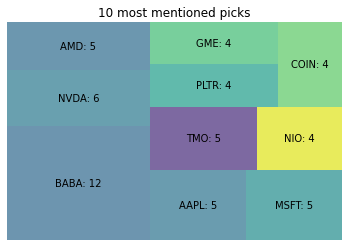

In [378]:
# Data Visualization
# Most mentioned picks
squarify.plot(sizes=times, label=top, alpha=.7)
plt.axis('off')
plt.title(f"{picks} most mentioned picks")
plt.show()

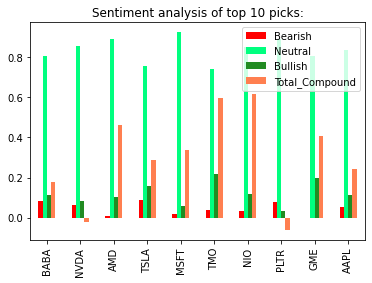

In [268]:
# Sentiment analysis
df = df.astype(float)
colors = ['red', 'springgreen', 'forestgreen', 'coral']
df.plot(kind='bar', color=colors, title=f"Sentiment analysis of top {picks_ayz} picks:")
plt.show()

In [269]:
# append date column to dataframe for storing in database
df['date'] = [date.today() - timedelta(days = 1) for x in range(df.shape[0])]


df.reset_index(inplace=True)
df.rename(columns={'index': 'stock'}, inplace=True)
df

,stock,Bearish,Neutral,Bullish,Total_Compound,date
0,BABA,0.084,0.805,0.111,0.177,2021-09-19
1,NVDA,0.062,0.856,0.082,-0.021,2021-09-19
2,AMD,0.010,0.888,0.102,0.463,2021-09-19
3,TSLA,0.088,0.754,0.158,0.289,2021-09-19
4,MSFT,0.020,0.922,0.058,0.335,2021-09-19
5,TMO,0.041,0.741,0.218,0.597,2021-09-19
6,NIO,0.035,0.849,0.116,0.618,2021-09-19
7,PLTR,0.077,0.888,0.034,-0.061,2021-09-19
8,GME,0.000,0.802,0.198,0.405,2021-09-19
9,AAPL,0.052,0.835,0.112,0.241,2021-09-19


In [270]:
# Save current top wsb stocks to csv file
df.to_csv('/content/drive/My Drive/Colab Notebooks/NLP Stock Project/df.csv')

In [271]:
from os import set_blocking
import requests
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt

In [291]:
# Load in df
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP Stock Project/df.csv', index_col=0)
df


,stock,Bearish,Neutral,Bullish,Total_Compound,date
0,BABA,0.084,0.805,0.111,0.177,2021-09-19
1,NVDA,0.062,0.856,0.082,-0.021,2021-09-19
2,AMD,0.010,0.888,0.102,0.463,2021-09-19
3,TSLA,0.088,0.754,0.158,0.289,2021-09-19
4,MSFT,0.020,0.922,0.058,0.335,2021-09-19
5,TMO,0.041,0.741,0.218,0.597,2021-09-19
6,NIO,0.035,0.849,0.116,0.618,2021-09-19
7,PLTR,0.077,0.888,0.034,-0.061,2021-09-19
8,GME,0.000,0.802,0.198,0.405,2021-09-19
9,AAPL,0.052,0.835,0.112,0.241,2021-09-19


In [292]:
# Request info from TD Ameritrade API
client_id = "SLUXSEU1HB6ECP386CT2N5ZOEQ5SAN16" # You can get one of these at developer.tdameritrade.com
stocks_list = list(df['stock'])

In [293]:
# The Quotes api call retrieves ticker information (price, etc.)
# The Fundamentals api call retrieves company information (market cap, p/e ratio, etc.)


In [294]:
# parameters
parameters_quotes = {
    'apikey': client_id,
    'symbol': stocks_list,
}

parameters_fund = {
    'apikey': client_id,
    'symbol': stocks_list,
    'projection': 'fundamental'
}


In [295]:
client_id = "SLUXSEU1HB6ECP386CT2N5ZOEQ5SAN16"

quotes_url = f'https://api.tdameritrade.com/v1/marketdata/quotes?apikey={client_id}'
fundamental_url = f'https://api.tdameritrade.com/v1/instruments?apikey={client_id}'


In [296]:
data_quotes = requests.get(url = quotes_url, params = parameters_quotes).json()
data_fundamental = requests.get(url = fundamental_url, params = parameters_fund).json()

In [297]:
data_quotes

{'AAPL': {'52WkHigh': 157.26,
  '52WkLow': 103.1,
  'askId': 'P',
  'askPrice': 141.66,
  'askSize': 500,
  'assetMainType': 'EQUITY',
  'assetType': 'EQUITY',
  'bidId': 'K',
  'bidPrice': 141.65,
  'bidSize': 900,
  'bidTick': ' ',
  'closePrice': 146.06,
  'cusip': '037833100',
  'delayed': True,
  'description': 'Apple Inc. - Common Stock',
  'digits': 4,
  'divAmount': 0.88,
  'divDate': '2021-08-06 00:00:00.000',
  'divYield': 0.6,
  'exchange': 'q',
  'exchangeName': 'NASD',
  'highPrice': 144.84,
  'lastId': 'D',
  'lastPrice': 141.66,
  'lastSize': 100,
  'lowPrice': 141.28,
  'marginable': True,
  'mark': 141.66,
  'markChangeInDouble': -4.4,
  'markPercentChangeInDouble': -3.0125,
  'nAV': 0.0,
  'netChange': -4.4,
  'netPercentChangeInDouble': -3.0125,
  'openPrice': 143.8,
  'peRatio': 28.6048,
  'quoteTimeInLong': 1632163518566,
  'realtimeEntitled': False,
  'regularMarketLastPrice': 141.66,
  'regularMarketLastSize': 1,
  'regularMarketNetChange': -4.4,
  'regularMarket

In [298]:
data_fundamental


{'AAPL': {'assetType': 'EQUITY',
  'cusip': '037833100',
  'description': 'Apple Inc. - Common Stock',
  'exchange': 'NASDAQ',
  'fundamental': {'beta': 1.21675,
   'bookValuePerShare': 0.0,
   'currentRatio': 1.06189,
   'divGrowthRate3Year': 0.0,
   'dividendAmount': 0.88,
   'dividendDate': '2021-08-06 00:00:00.000',
   'dividendPayAmount': 0.22,
   'dividendPayDate': '2021-08-12 00:00:00.000',
   'dividendYield': 0.6,
   'epsChange': 0.0,
   'epsChangePercentTTM': 55.23408,
   'epsChangeYear': 100.5681,
   'epsTTM': 5.10613,
   'grossMarginMRQ': 43.29273,
   'grossMarginTTM': 41.00503,
   'high52': 157.26,
   'interestCoverage': 0.0,
   'low52': 103.1,
   'ltDebtToEquity': 164.5177,
   'marketCap': 2414396.0,
   'marketCapFloat': 16360.92,
   'netProfitMarginMRQ': 26.70138,
   'netProfitMarginTTM': 25.00382,
   'operatingMarginMRQ': 29.62645,
   'operatingMarginTTM': 28.78772,
   'pbRatio': 37.62145,
   'pcfRatio': 24.68733,
   'peRatio': 28.60483,
   'pegRatio': 0.517884,
   'prRa

In [299]:
# quotes dataframe
df_q = pd.DataFrame.from_dict(data_quotes, orient = 'index')
df_q.reset_index(inplace=True)
df_q.drop('index', axis=1, inplace=True)
df_q

,assetType,assetMainType,cusip,assetSubType,symbol,description,bidPrice,bidSize,bidId,askPrice,askSize,askId,lastPrice,lastSize,lastId,openPrice,highPrice,lowPrice,bidTick,closePrice,netChange,totalVolume,quoteTimeInLong,tradeTimeInLong,mark,exchange,exchangeName,marginable,shortable,volatility,digits,52WkHigh,52WkLow,nAV,peRatio,divAmount,divYield,divDate,securityStatus,regularMarketLastPrice,regularMarketLastSize,regularMarketNetChange,regularMarketTradeTimeInLong,netPercentChangeInDouble,markChangeInDouble,markPercentChangeInDouble,regularMarketPercentChangeInDouble,delayed,realtimeEntitled
0,EQUITY,EQUITY,01609W102,ADR,BABA,Alibaba Group Holding Limited American Deposit...,149.84,200,H,149.86,300,P,149.8600,100,D,154.4000,155.1400,149.54,,160.05,-10.1900,27191297,1632163517615,1632163517637,149.8600,n,NYSE,True,True,0.0211,2,319.32,149.540,0.0,19.2712,0.00,0.00,,Normal,149.8600,1,-10.1900,1632163517637,-6.3668,-10.1900,-6.3668,-6.3668,True,False
1,EQUITY,EQUITY,67066G104,NaN,NVDA,NVIDIA Corporation - Common Stock,206.96,100,Q,206.99,200,Q,206.9800,100,Q,211.4600,214.3300,206.62,,219.00,-12.0200,25088094,1632163518326,1632163518187,206.9800,q,NASD,True,True,0.0304,4,230.43,115.665,0.0,78.2529,0.16,0.07,2021-08-31 00:00:00.000,Normal,206.9800,1,-12.0200,1632163518187,-5.4886,-12.0200,-5.4886,-5.4886,True,False
2,EQUITY,EQUITY,007903107,NaN,AMD,"Advanced Micro Devices, Inc. - Common Stock",99.70,100,K,99.71,500,Q,99.7100,100,U,101.5800,102.5100,99.51,,103.88,-4.1700,34936923,1632163518521,1632163517640,99.7100,q,NASD,True,True,0.0290,4,122.49,72.500,0.0,37.0782,0.00,0.00,,Normal,99.7100,1,-4.1700,1632163517640,-4.0142,-4.1700,-4.0142,-4.0142,True,False
3,EQUITY,EQUITY,88160R101,NaN,TSLA,"Tesla, Inc. - Common Stock",722.25,100,H,722.60,200,H,722.6000,100,D,734.5577,742.0000,721.06,,759.49,-36.8900,18448458,1632163518401,1632163517821,722.6000,q,NASD,True,True,0.0265,4,900.40,351.300,0.0,397.1418,0.00,0.00,,Normal,722.6000,1,-36.8900,1632163517821,-4.8572,-36.8900,-4.8572,-4.8572,True,False
4,EQUITY,EQUITY,594918104,NaN,MSFT,Microsoft Corporation - Common Stock,291.25,200,Q,291.27,100,Y,291.2600,100,P,296.3300,298.7200,290.75,,299.87,-8.6100,22227456,1632163518566,1632163518535,291.2600,q,NASD,True,True,0.0137,4,305.84,196.250,0.0,37.2275,2.48,0.83,2021-11-17 00:00:00.000,Normal,291.2600,1,-8.6100,1632163518535,-2.8712,-8.6100,-2.8712,-2.8712,True,False
5,EQUITY,EQUITY,883556102,NaN,TMO,Thermo Fisher Scientific Inc Common Stock,586.44,100,N,586.97,100,Y,586.5900,100,H,592.6900,602.1900,585.00,,596.80,-10.2100,1800641,1632163518232,1632163517761,586.5900,n,NYSE,True,True,0.0533,2,609.30,412.800,0.0,27.6193,1.04,0.17,2021-09-14 00:00:00.000,Normal,586.5900,1,-10.2100,1632163517761,-1.7108,-10.2100,-1.7108,-1.7108,True,False
6,EQUITY,EQUITY,62914V106,ADR,NIO,"NIO Inc. American depositary shares, each rep...",34.69,300,Z,34.70,1400,A,34.6959,200,D,36.1100,36.3150,34.58,,37.51,-2.8141,46837166,1632163518439,1632163518434,34.6959,n,NYSE,True,True,0.0230,2,66.99,16.750,0.0,0.0000,0.00,0.00,,Normal,34.6959,2,-2.8141,1632163518434,-7.5023,-2.8141,-7.5023,-7.5023,True,False
7,EQUITY,EQUITY,69608A108,NaN,PLTR,Palantir Technologies Inc. Class A Common Stock,26.39,600,P,26.40,1300,P,26.3950,900,D,27.5700,28.0999,26.37,,28.71,-2.3150,67383822,1632163518532,1632163518250,26.3950,n,NYSE,True,True,0.0274,2,45.00,8.900,0.0,0.0000,0.00,0.00,,Normal,26.3950,9,-2.3150,1632163518250,-8.0634,-2.3150,-8.0634,-8.0634,True,False
8,EQUITY,EQUITY,36467W109,NaN,GME,GameStop Corporation Common Stock,186.50,100,V,186.74,100,N,186.5900,100,Z,200.0000,202.8499,185.05,,204.97,-18.3800,2704183,1632163517851,1632163516573,186.5900,n,NYSE,True,True,0.0878,2,483.00,8.380,0.0,0.0000,0.00,0.00,,Normal,186.5900,1,-18.3800,1632163516573,-8.9672,-18.3800,-8.9672,-8.9672,True,False
9,EQUITY,EQUITY,037833100,NaN,AAPL,Apple Inc. - Common Stock,141.65,900,K,141.66,500,P,141.6600,100,D,143.8000,144.8400,141.28,,146.06,-4.4000,82371767,1632163518566,1632163518535,141.6600,q,N

In [300]:
# Establish fund columns for dataframe
fund_cols = []
for column in [x for x in [*data_fundamental[stocks_list[0]]['fundamental']]]:
    fund_cols.append(column)
fund_cols

['symbol',
 'high52',
 'low52',
 'dividendAmount',
 'dividendYield',
 'dividendDate',
 'peRatio',
 'pegRatio',
 'pbRatio',
 'prRatio',
 'pcfRatio',
 'grossMarginTTM',
 'grossMarginMRQ',
 'netProfitMarginTTM',
 'netProfitMarginMRQ',
 'operatingMarginTTM',
 'operatingMarginMRQ',
 'returnOnEquity',
 'returnOnAssets',
 'returnOnInvestment',
 'quickRatio',
 'currentRatio',
 'interestCoverage',
 'totalDebtToCapital',
 'ltDebtToEquity',
 'totalDebtToEquity',
 'epsTTM',
 'epsChangePercentTTM',
 'epsChangeYear',
 'epsChange',
 'revChangeYear',
 'revChangeTTM',
 'revChangeIn',
 'sharesOutstanding',
 'marketCapFloat',
 'marketCap',
 'bookValuePerShare',
 'shortIntToFloat',
 'shortIntDayToCover',
 'divGrowthRate3Year',
 'dividendPayAmount',
 'dividendPayDate',
 'beta',
 'vol1DayAvg',
 'vol10DayAvg',
 'vol3MonthAvg']

In [301]:
# Append data to dataframe
df_f = pd.DataFrame(columns = fund_cols)
for stock in stocks_list:
    df_f = df_f.append(pd.Series(data_fundamental[stock]['fundamental'], index=fund_cols), ignore_index=True)


In [302]:
df_f

,symbol,high52,low52,dividendAmount,dividendYield,dividendDate,peRatio,pegRatio,pbRatio,prRatio,pcfRatio,grossMarginTTM,grossMarginMRQ,netProfitMarginTTM,netProfitMarginMRQ,operatingMarginTTM,operatingMarginMRQ,returnOnEquity,returnOnAssets,returnOnInvestment,quickRatio,currentRatio,interestCoverage,totalDebtToCapital,ltDebtToEquity,totalDebtToEquity,epsTTM,epsChangePercentTTM,epsChangeYear,epsChange,revChangeYear,revChangeTTM,revChangeIn,sharesOutstanding,marketCapFloat,marketCap,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,BABA,319.32,152.800,0.00,0.00,,19.27123,0.000000,2.87726,3.65639,15.96230,40.10241,39.68261,16.50301,17.85846,11.15592,14.99320,16.57410,8.23204,11.43016,0.00000,1.75757,0.00000,11.86642,13.57898,15.30818,8.30513,0.00000,0.00000,0.0,0.0,40.24151,9.78948,2.168731e+10,1999.58400,435044.60,31.75647,0.0,0.0,0.0,0.000,,0.80560,21035380.0,21048546.0,4.963961e+08
1,NVDA,230.43,115.665,0.16,0.07,2021-08-31 00:00:00.000,78.25285,0.743465,25.84877,25.00343,66.50067,63.75303,64.77639,32.32863,36.48379,33.36073,37.55955,40.38105,22.18079,24.85080,5.32644,5.80171,54.29167,36.09248,51.74729,56.47610,2.79862,105.25420,277.45570,0.0,0.0,67.60046,14.94436,2.492000e+09,2398.03500,547500.00,26.81698,0.0,0.0,0.0,0.040,2021-09-23 00:00:00.000,1.37922,22890040.0,22929339.0,6.764422e+08
2,AMD,122.49,72.500,0.00,0.00,,37.07815,0.082301,17.83531,9.44549,33.22860,45.71214,47.53247,25.69715,18.38961,18.32084,21.58442,66.26808,39.68971,57.38199,2.09302,2.70332,83.00000,4.24234,4.43029,4.43029,2.80165,450.51970,341.94780,0.0,0.0,74.47031,11.75617,1.212965e+09,1207.74300,126002.80,0.00000,0.0,0.0,0.0,0.000,,2.00849,37790540.0,37804195.0,1.304315e+09
3,TSLA,900.40,351.300,0.00,0.00,,397.14180,1.083121,30.12974,17.96155,156.28900,22.04386,24.11775,5.51096,9.85115,7.85916,10.97173,12.40659,4.94634,7.47667,1.21923,1.50834,89.00000,26.36953,31.73279,37.90114,1.91239,366.66420,915.67470,0.0,0.0,62.83736,15.10251,9.900152e+08,802.29140,751906.60,69.61395,0.0,0.0,0.0,0.000,,1.94730,18224170.0,18232842.0,4.167310e+08
4,MSFT,305.84,196.250,2.48,0.83,2021-11-17 00:00:00.000,37.22749,0.936721,15.87967,13.40661,30.88793,68.92580,69.68495,36.45174,35.66043,41.58714,41.38499,47.07867,19.29522,25.84604,2.05026,2.07999,0.00000,33.23710,43.54171,49.78378,8.05507,39.74234,48.31527,0.0,0.0,17.53173,10.66034,7.514891e+09,7508.82900,2253491.00,15.41530,0.0,0.0,0.0,0.620,2021-12-09 00:00:00.000,0.78043,22111270.0,22132883.0,4.665179e+08
5,TMO,609.30,412.800,1.04,0.17,2021-09-14 00:00:00.000,27.61931,0.209140,6.37088,6.13836,21.24049,51.29412,48.78680,22.47320,19.71315,27.99739,23.32578,25.76391,13.29714,14.77573,2.11336,2.78123,20.18018,33.75276,50.93884,50.94969,21.60807,132.06110,58.93022,0.0,0.0,45.72539,0.00000,3.934189e+08,392.62810,234792.40,10.24190,0.0,0.0,0.0,0.260,2021-10-15 00:00:00.000,0.73868,1491300.0,1492754.0,2.517063e+07
6,NIO,66.99,16.750,0.00,0.00,,0.00000,0.000000,14.05045,14.39898,0.00000,17.59759,18.63059,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.38211,2.48135,0.00000,34.01640,37.16102,58.77129,0.00000,30.17159,63.19121,0.0,0.0,182.29620,5.83431,1.361724e+09,1077.62500,61460.81,0.00000,0.0,0.0,0.0,0.066,2016-05-02 00:00:00.000,0.00000,33938100.0,33951864.0,1.062206e+09
7,PLTR,45.00,8.900,0.00,0.00,,0.00000,0.000000,26.87296,42.19220,0.00000,71.02534,75.79451,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.90068,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,10.08340,1.866000e+09,1626.48400,56045.30,0.00000,0.0,0.0,0.0,0.000,,0.00000,60668310.0,60708398.0,9.346663e+08
8,GME,483.00,8.380,0.00,0.00,,0.00000,0.000000,8.40023,2.80624,1866.48400,24.62681,27.11678,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.72536,2.22473,0.00000,2.50066,2.56479,2.56479,0.00000,81.24484,50.31417,0.0,0.0,0.00000,0.00000,7.649150e+07,62.86367,15678.46,0.00000,0.0,0.0,0.0,0.380,2019-07-01 0

In [303]:
# Combine both dataframes
# Remove duplicates
current = pd.concat([df, df_q, df_f], axis=1)
current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Columns: 101 entries, stock to vol3MonthAvg
dtypes: bool(4), float64(69), int64(9), object(19)
memory usage: 7.7+ KB


In [304]:
current = current.loc[:, ~current.columns.duplicated()]
current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 99 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   stock                               10 non-null     object 
 1   Bearish                             10 non-null     float64
 2   Neutral                             10 non-null     float64
 3   Bullish                             10 non-null     float64
 4   Total_Compound                      10 non-null     float64
 5   date                                10 non-null     object 
 6   assetType                           10 non-null     object 
 7   assetMainType                       10 non-null     object 
 8   cusip                               10 non-null     object 
 9   assetSubType                        2 non-null      object 
 10  symbol                              10 non-null     object 
 11  description                         10 non-null 

In [305]:
# Read csv
historic_sentiment_analysis = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP Stock Project/historic_sentiment_analysis.csv')
#historic_sentiment_analysis = historic_sentiment_analysis.iloc[:, 1:]
historic_sentiment_analysis.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 100 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   stock                               805 non-null    object 
 1   Bearish                             805 non-null    float64
 2   Neutral                             805 non-null    float64
 3   Bullish                             805 non-null    float64
 4   Total_Compound                      805 non-null    float64
 5   date                                805 non-null    object 
 6   assetType                           805 non-null    object 
 7   assetMainType                       805 non-null    object 
 8   cusip                               805 non-null    object 
 9   symbol                              805 non-null    object 
 10  description                         805 non-null    object 
 11  bidPrice                            805 non-

In [306]:

# Remove duplicates
#historic_sentiment_analysis = historic_sentiment_analysis.loc[:, ~historic_sentiment_analysis.columns.duplicated()]
historic_sentiment_analysis.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 100 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   stock                               805 non-null    object 
 1   Bearish                             805 non-null    float64
 2   Neutral                             805 non-null    float64
 3   Bullish                             805 non-null    float64
 4   Total_Compound                      805 non-null    float64
 5   date                                805 non-null    object 
 6   assetType                           805 non-null    object 
 7   assetMainType                       805 non-null    object 
 8   cusip                               805 non-null    object 
 9   symbol                              805 non-null    object 
 10  description                         805 non-null    object 
 11  bidPrice                            805 non-

In [307]:
# Update csv
historic_sentiment_analysis = pd.concat([historic_sentiment_analysis, current], axis = 0, ignore_index=True)
historic_sentiment_analysis.to_csv('/content/drive/My Drive/Colab Notebooks/NLP Stock Project/historic_sentiment_analysis1.csv', index=False)


In [308]:

from os import set_blocking
import requests
import pandas as pd
import numpy as np
from datetime import date
import plotly.graph_objects as go

In [309]:
# Import data and convert date column to datetime datatype
historic_sentiment_analysis = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP Stock Project/historic_sentiment_analysis1.csv')
historic_sentiment_analysis['date'] = pd.to_datetime(historic_sentiment_analysis['date'])
historic_sentiment_analysis.head()

,stock,Bearish,Neutral,Bullish,Total_Compound,date,assetType,assetMainType,cusip,symbol,description,bidPrice,bidSize,bidId,askPrice,askSize,askId,lastPrice,lastSize,lastId,openPrice,highPrice,lowPrice,bidTick,closePrice,netChange,totalVolume,quoteTimeInLong,tradeTimeInLong,mark,exchange,exchangeName,marginable,shortable,volatility,digits,52WkHigh,52WkLow,nAV,peRatio,...,pegRatio,pbRatio,prRatio,pcfRatio,grossMarginTTM,grossMarginMRQ,netProfitMarginTTM,netProfitMarginMRQ,operatingMarginTTM,operatingMarginMRQ,returnOnEquity,returnOnAssets,returnOnInvestment,quickRatio,currentRatio,interestCoverage,totalDebtToCapital,ltDebtToEquity,totalDebtToEquity,epsTTM,epsChangePercentTTM,epsChangeYear,epsChange,revChangeYear,revChangeTTM,revChangeIn,sharesOutstanding,marketCapFloat,marketCap,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg,assetSubType
0,CLOV,0.036,0.749,0.215,0.328,2021-06-03,EQUITY,EQUITY,18914F103,CLOV,"Clover Health Investments, Corp. - Class A Co...",8.98,600,P,9.03,6800,P,9.03,100,P,10.010,10.4600,8.55,,8.74,0.29,48643300,1.620000e+12,1.620000e+12,8.98,q,NASD,True,True,0.0684,4,17.45,6.3100,0.0,0.0000,...,0.000000,6.09677,17.80508,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,4.67822,0.0,7.20245,4.15105,7.81325,0.00000,0.00000,0.0000,0.0,0.0,0.00000,0.00000,1.482792e+08,112.0982,3566.803,0.0,0.0,0.0,0.0,0.00,,0.00000,13468700.0,13468699.0,4.771102e+08,NaN
1,CLNE,0.017,0.789,0.194,0.398,2021-06-03,EQUITY,EQUITY,184499101,CLNE,Clean Energy Fuels Corp. - Common Stock,9.61,500,Q,9.66,500,P,9.66,400,P,8.420,9.7400,8.42,,8.13,1.53,30229468,1.620000e+12,1.620000e+12,9.61,q,NASD,True,True,0.0628,4,19.79,2.0100,0.0,0.0000,...,0.000000,3.17260,5.74604,58.85038,35.34669,34.66549,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,2.91098,3.23167,0.0,14.77244,16.16143,17.63983,0.00000,0.00000,0.0000,0.0,0.0,0.00000,2.91497,1.999176e+08,145.7305,1625.330,0.0,0.0,0.0,0.0,0.00,,1.84330,5293610.0,5293614.0,1.434198e+08,NaN
2,TLRY,0.117,0.786,0.097,0.018,2021-06-03,EQUITY,EQUITY,88688T100,TLRY,"Tilray, Inc. - Class 2 Common Stock",19.80,1700,P,19.81,300,P,19.81,0,P,20.665,22.1401,19.10,,19.00,0.81,84515471,1.620000e+12,1.620000e+12,19.80,q,NASD,True,True,0.0440,4,67.00,4.4100,0.0,0.0000,...,0.000000,15.72247,41.18224,0.00000,13.22087,28.11895,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,1.67410,2.01405,0.0,36.36798,47.98892,57.15359,0.00000,39.16053,0.0000,0.0,0.0,5.28353,0.00000,4.473713e+08,426.0380,8500.055,0.0,0.0,0.0,0.0,0.00,,0.00000,28527700.0,28527703.0,4.933556e+08,NaN
3,AAPL,0.080,0.720,0.200,0.174,2021-06-03,EQUITY,EQUITY,37833100,AAPL,Apple Inc. - Common Stock,123.62,700,P,123.65,600,P,123.62,0,D,124.680,124.8500,123.13,,125.06,-1.44,76108984,1.620000e+12,1.620000e+12,123.62,q,NASD,True,True,0.0124,4,145.09,79.7325,0.0,27.8877,...,0.706086,30.16550,6.41339,23.92529,39.88126,42.50647,23.45101,26.37748,27.32064,30.70079,103.4003,23.21042,33.53747,1.09269,1.14175,0.0,63.74756,157.04700,175.84350,4.45645,39.74400,118.6195,0.0,0.0,21.42876,0.00000,1.668763e+10,16676.6600,2086955.000,0.0,0.0,0.0,0.0,0.22,00:00.0,1.20359,73329560.0,73329559.0,2.016039e+09,NaN
4,WKHS,0.119,0.764,0.117,-0.019,2021-06-03,EQUITY,EQUITY,98138J206,WKHS,"Workhorse Group, Inc. - Common Stock",14.46,200,P,14.48,1200,P,14.48,0,D,14.390,18.3317,13.10,,11.52,2.96,155713083,1.620000e+12,1.620000e+12,14.48,q,NASD,True,True,0.0792,4,42.96,2.5600,0.0,0.0000,...,0.000000,5.15194,776.23920,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,24.88475,26.63235,0.0,39.79867,66.10929,66.10929,0.00000,0.00000,0.0000,0.0,0.0,1792.09800,0.00000,1.232603e+08,112.6857,1419.959,0.0,0.0,0.0,0.0,0.00,,2.63773,11332520.0,11332520.0,2.795409e+08,NaN


In [310]:
def plot_sentiment_trends(df = historic_sentiment_analysis):
    '''
    Input: dataframe
    Output: 4 trend graphs (Bullish, Bearish, Neutral, Total_Compound)
    '''
    sentiment_list = ['Bullish', 'Bearish', 'Neutral', 'Total_Compound']

    for sentiment in sentiment_list:
        fig = go.Figure()
        for stock in historic_sentiment_analysis['stock'].unique():

            fig.add_trace(go.Line(x=historic_sentiment_analysis[historic_sentiment_analysis['stock'] == stock]['date'],
                                y=historic_sentiment_analysis[historic_sentiment_analysis['stock'] == stock][sentiment],
                                mode='lines',
                                name=f'{stock}'))

        fig.update_layout(title=f'WSB {sentiment} Sentiment',
                        xaxis_title='Date',
                        yaxis_title='Sentiment Score')

        fig.show()

plot_sentiment_trends(historic_sentiment_analysis)

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


